In [1]:
from nnAudio import Spectrogram
from Installation.nnAudio import Spectrogram # Use it during testing

from librosa import filters
import numpy as np
import matplotlib.pyplot as plt
from time import time
import torch

In [2]:
# Use cpu if GPU is not found
device='cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Creating a dummy signal for the tests later

fs = 22050
s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*50*s, dtype=np.float32) + np.sin(2*np.pi*100*s, dtype=np.float32) \
    + np.sin(2*np.pi*200*s, dtype=np.float32) + np.sin(2*np.pi*400*s, dtype=np.float32) \
    + np.sin(2*np.pi*800*s, dtype=np.float32) + np.sin(2*np.pi*1600*s, dtype=np.float32) \
    + np.sin(2*np.pi*3200*s, dtype=np.float32) + np.sin(2*np.pi*6400*s, dtype=np.float32)


# STFT

In [4]:
from librosa.core import stft

### nnAudio

In [5]:
spec_layer = Spectrogram.STFT(hop_length=512, n_fft=2048, window='hann'
                                    , freq_scale='no', device=device)

spec = spec_layer(torch.tensor(x, device=device))

STFT kernels created, time used = 4.3405 seconds


### librosa

In [6]:
librosa_spec = np.abs(stft(x, hop_length=512, n_fft=2048, window='hann'))

Text(0.5, 1.0, 'librosa')

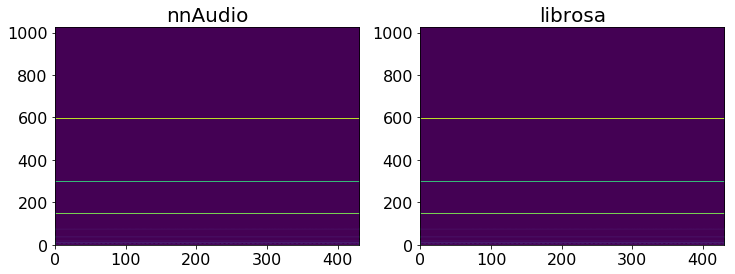

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(spec[0].cpu().numpy(),aspect='auto', origin='lower')
ax[0].tick_params(labelsize=16)
ax[0].set_title('nnAudio', size=20)

ax[1].imshow(librosa_spec, aspect='auto', origin='lower')
ax[1].tick_params(labelsize=16)
ax[1].set_title('librosa', size=20)

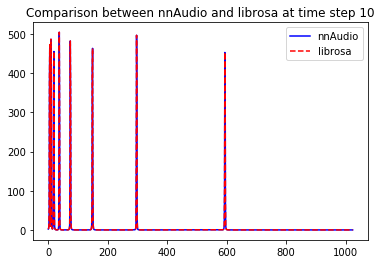

In [8]:
time_step = 10
plt.plot(spec[0][:,time_step].cpu().numpy(), 'b')
plt.plot(librosa_spec[:,10], '--r')
plt.title(f'Comparison between nnAudio and librosa at time step {time_step}')
plt.legend(['nnAudio', 'librosa'])

In [9]:
np.allclose(librosa_spec, spec[0].cpu().numpy(),rtol=1e-4, atol=1e-4)

True

### Extra functions provided in nnAudio

#### Setting the frequency range for the spectrogram for linear freq scale from 0Hz to 7000Hz

sampling rate = 22050. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.1999 seconds


Text(0, 0.5, 'freq (Hz)')

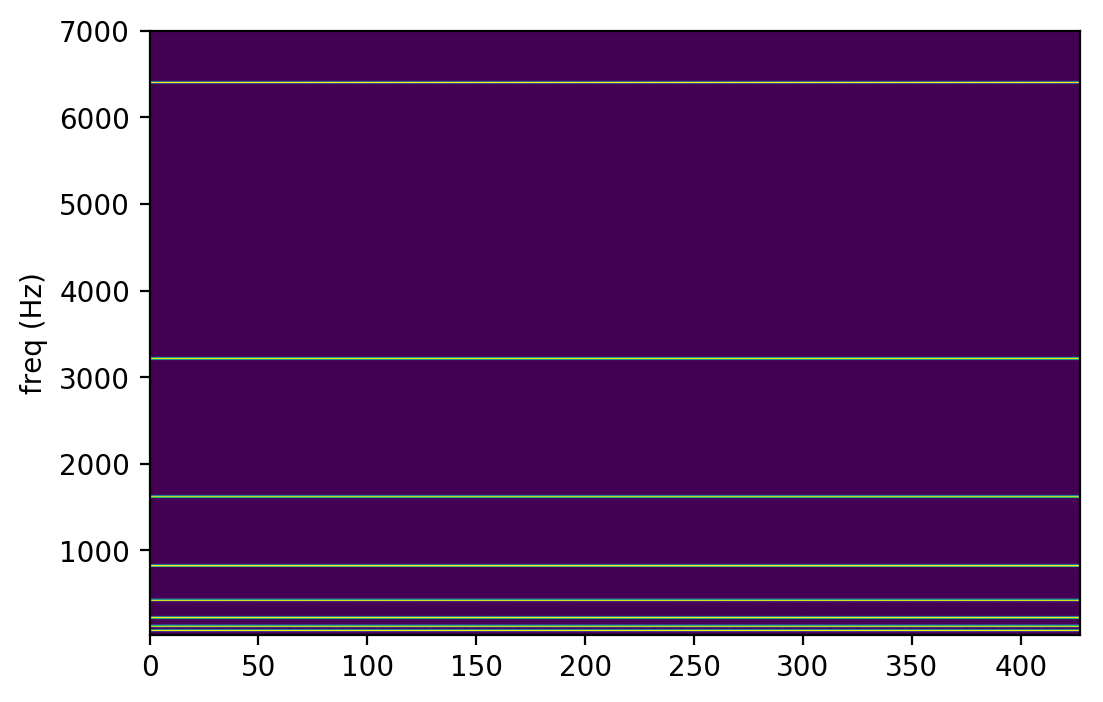

In [10]:
fmin=0
fmax = 7000
spec_layer = Spectrogram.STFT(hop_length=512, n_fft=2048,center=False, window='hann'
                                    , freq_scale='linear', fmin=fmin, fmax=fmax, device=device)
plt.figure(dpi=200) # Need a higher resolution to see the fine lines
spec = spec_layer(torch.tensor(x, device=device))
plt.imshow(spec[0].cpu().numpy(), aspect='auto', origin='lower',extent=[0,spec[0].shape[1],30,7000])
plt.ylabel("freq (Hz)")

#### Log freq scale spectrogram

sampling rate = 22050. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.1954 seconds


Text(0, 0.5, 'freq (Hz)')

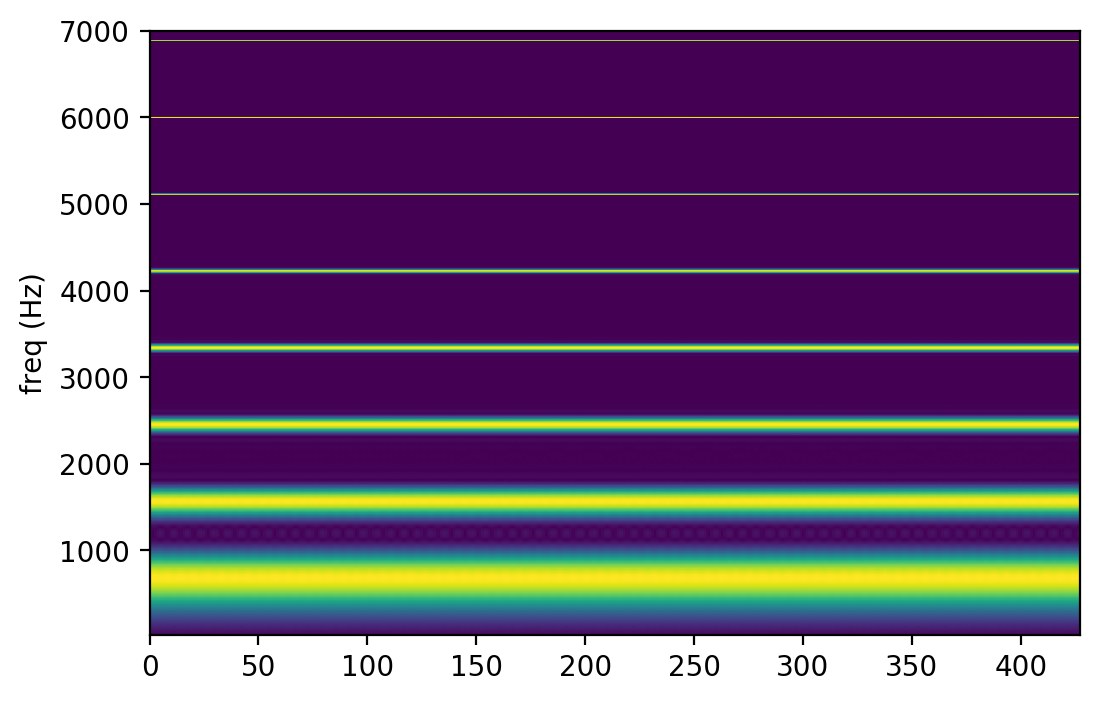

In [11]:
fmin=30
fmax = 7000

spec_layer = Spectrogram.STFT(hop_length=512, n_fft=2048,center=False, window='hann'
                                    , freq_scale='log', fmin=fmin, fmax=fmax, device=device)
spec = spec_layer(torch.tensor(x, device=device))
plt.figure(dpi=200) # Need a higher resolution to see the fine lines
plt.imshow(spec[0].cpu().numpy(), aspect='auto', origin='lower',extent=[0,spec[0].shape[1],30,fmax])
plt.ylabel("freq (Hz)")

# Melspectrogram

In [12]:
from librosa.feature import melspectrogram

### nnAudio

In [13]:
spec_layer = Spectrogram.MelSpectrogram(sr=22050, n_fft=2048, n_mels=128, hop_length=512,
                                        window='hann', center=True, pad_mode='reflect', 
                                        power=2.0, htk=False, fmin=0.0, fmax=None, norm=1, 
                                        verbose=True, device='cuda:0')

spec = spec_layer(torch.tensor(x, device=device))

STFT filter created, time used = 0.0029 seconds
Mel filter created, time used = 0.0029 seconds


### librosa

In [14]:
librosa_spec = melspectrogram(x)

### Full Spectrograms

Text(0.5, 1.0, 'librosa')

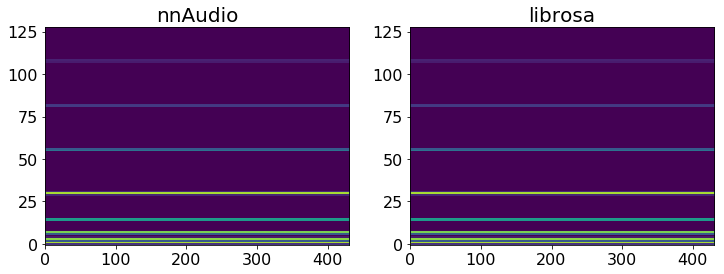

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(spec[0].cpu().numpy(),aspect='auto', origin='lower')
ax[0].tick_params(labelsize=16)
ax[0].set_title('nnAudio', size=20)

ax[1].imshow(librosa_spec, aspect='auto', origin='lower')
ax[1].tick_params(labelsize=16)
ax[1].set_title('librosa', size=20)

### Spectrum at time step 10

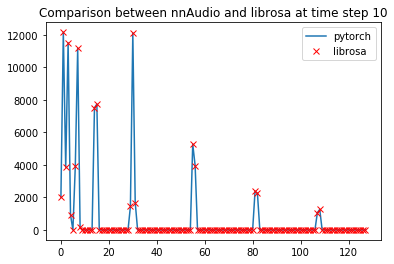

In [16]:
time_step = 10
plt.plot(spec[0].cpu().numpy()[:,time_step])
plt.plot(librosa_spec[:,10], 'rx')
plt.title(f'Comparison between nnAudio and librosa at time step {time_step}')
plt.legend(['pytorch', 'librosa'])

In [17]:
np.allclose(spec[0].cpu().numpy(), librosa_spec, 1e-4, 1e-4)

True

# CQT

In [18]:
from librosa.core import cqt, note_to_hz

bins = 24 # bins per octave
n_bins = 192
fmin = note_to_hz('C1')
stride = 512

### nnAudio

In [19]:
# Initializing conv1d for CQT 1992 version
spec_layer = Spectrogram.CQT1992v2(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins, norm=1,center=True,
                        pad_mode='reflect')
spec = spec_layer(torch.tensor(x, device=device))
cqt1992 = spec.cpu().numpy() # saving to RAM for plotting later

CQT kernels created, time used = 0.2045 seconds


In [20]:
# Initializing conv1d for CQT 2010v2 version
spec_layer = Spectrogram.CQT2010v2(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins,
                        pad_mode='reflect', earlydownsample=False)

spec = spec_layer(torch.tensor(x, device=device))
cqt2010 = spec.cpu().numpy() # saving to RAM for plotting later

Low pass filter created, time used = 0.0009 seconds
num_octave =  8
CQT kernels created, time used = 0.0066 seconds


### Librosa

In [21]:
librosa_spec = abs(cqt(x, fs, stride, fmin, n_bins=n_bins,
                       bins_per_octave=bins))

Text(0.5, 1.0, 'librosa')

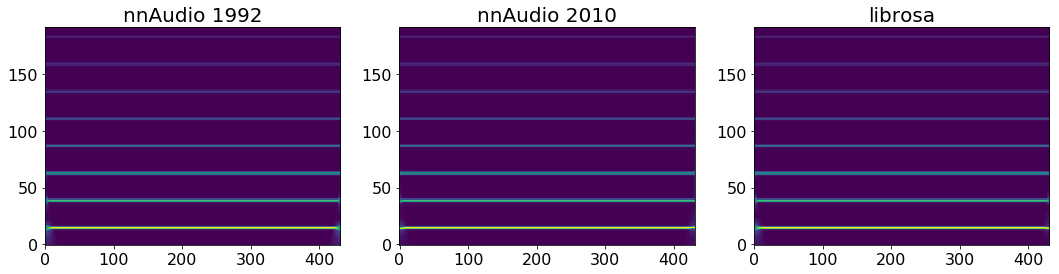

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))
ax[0].imshow(cqt1992[0],aspect='auto', origin='lower')
ax[0].tick_params(labelsize=16)
ax[0].set_title('nnAudio 1992', size=20)

ax[1].imshow(cqt2010[0], aspect='auto', origin='lower')
ax[1].tick_params(labelsize=16)
ax[1].set_title('nnAudio 2010', size=20)

ax[2].imshow(abs(librosa_spec), aspect='auto', origin='lower')
ax[2].tick_params(labelsize=16)
ax[2].set_title('librosa', size=20)

Text(0.5, 1.0, 'Comparison between nnAudio and librosa at time step 20')

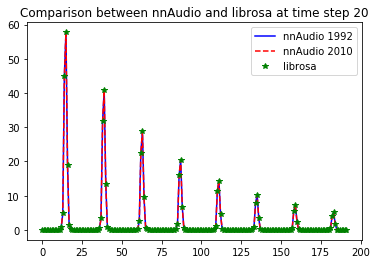

In [23]:
time_step = 20
plt.plot(cqt1992[0][:,time_step], 'b')
plt.plot(cqt2010[0][:,time_step], 'r--')
plt.plot(librosa_spec[:,time_step], 'g*')
plt.legend(['nnAudio 1992', 'nnAudio 2010', 'librosa'])
# plt.tick_params(labelsize=16)
plt.title(f'Comparison between nnAudio and librosa at time step {time_step}')